<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_6_Point_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021 Sudeep Sarkar, University of South Florida, Tampa 



# Point Features

Figure 4.2 and 4.3 in the textbook

Point features are stable with respect to viewpoint and lighting.


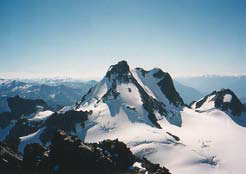
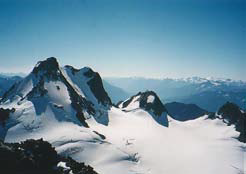


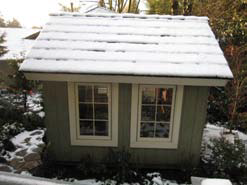
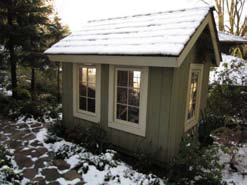


One possible matching criterion to track points across video frames or match points across images is the **weighted sum of squared differences**.

\begin{equation}
    E_{WSSD}(\mathbf{u}) = \sum_i w(\mathbf{x}_i) \left (
        I_{1} (\mathbf{x}_i + \mathbf{u}) - I_0(\mathbf{x}_i) 
        \right )^2
\end{equation}

The value of this would be low when regions match but could also be low for other reasons, such as uniform colored patches.

Computationally, we will have to try to match every pixel to all other pixels in the other image to find matches. This matching process is computationally expensive and ambiguous for many points, such as along an edge or uniform colored surface.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/mountain_peak_1.png


Mounted at /content/drive
'/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png'


Input image size: (174, 246)
(25, 25)
(43, 23)


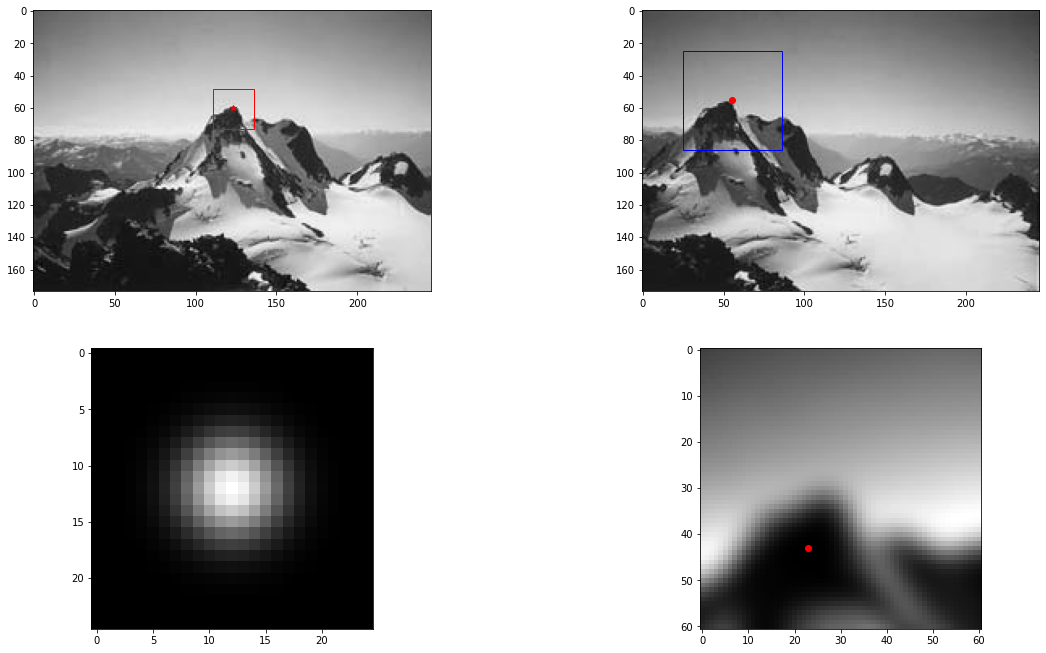

In [3]:
#------------------------------------------------------------------
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as scimage

np.set_printoptions(precision=2)
                     
def gaussian_weights (sigma) :
    N = np.round(3*(sigma+1))
    t = np.arange(-N, N+1)  # Note the width of the kernel, need to be this large to capture most of the shape
    g_2D = np.zeros ([2*N+1, 2*N+1])
    for i in range (-N, N+1):
        for j in range (-N, N+1):
            g_2D [i+N, j+N] = np.exp(-((i**2 + j**2)/(2*sigma*sigma)))*(1/(2*np.pi*sigma*sigma))
    return (g_2D/g_2D.sum())


# Load an color image in grayscale
img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png')

img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_2.png')

# Change color spaces. Can experiment with other spaces.
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img1 = img1.astype(np.float)  # need to change type from uint8 to float
img2 = img2.astype(np.float)  # need to change type from uint8 to float
print("Input image size:", img1.shape)

# Compute E_WSSD over a (2Nw+1) by (2Nw+1) region for a point p in img1 computed 
# across a region (2Ns + 1) by (2Ns + 1) region in the img2 centered at point q
# in reality you will have to over all possible choices of p and q
px, py = (123, 60) # point in image 1
qx, qy = (55, 55) # point in image 2
sigma = 3
Nw = np.round(3*(sigma+1)) # averaging window
Ns = 30 # matching search region is (2Ns + 1) by (2Ns + 1)

weights = gaussian_weights (sigma)
print(weights.shape)

out = np.zeros([2*Ns+1, 2*Ns+1])
for i in range (-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        patch1 = img1[px-Nw : px+Nw+1, py-Nw : py+Nw+1]
        patch2 = img2[qx+i-Nw : qx+i+Nw+1 , qy+j-Nw : qy+j+Nw+1]
        out[i+Ns, j+Ns]  =  (weights*(patch1 - patch2)**2).sum()

#-----------------------------------------------------------------------------
# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
plt.imshow(img1, 'gray')
plt.plot (123, 60, 'r*')
rect = patches.Rectangle((px-Nw,py-Nw),weights.shape[0], weights.shape[1],linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)

plt.subplot(5,2,2)
plt.imshow(img2, 'gray')
plt.plot (55, 55, 'ro')
rect = patches.Rectangle((qx-Ns,qy-Ns),out.shape[0], out.shape[1],linewidth=1,edgecolor='b',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)

plt.subplot(5,2,3)
plt.imshow(weights, 'gray')
plt.subplot(5,2,4)
plt.imshow(out, 'gray')
print(np.unravel_index(np.argmin(out, axis=None), out.shape))

i_min, j_min = (np.unravel_index(np.argmin(out, axis=None), out.shape)) 
plt.plot (j_min, i_min, 'ro')


#plt.imshow(gaussian_weights (3), 'gray')

How can one **pre-select** a limited number of points to match? Find points in the image so that the error criterion, whatever it maybe, is stable with respect to small variations, on the same image. (see Fig 4.5)

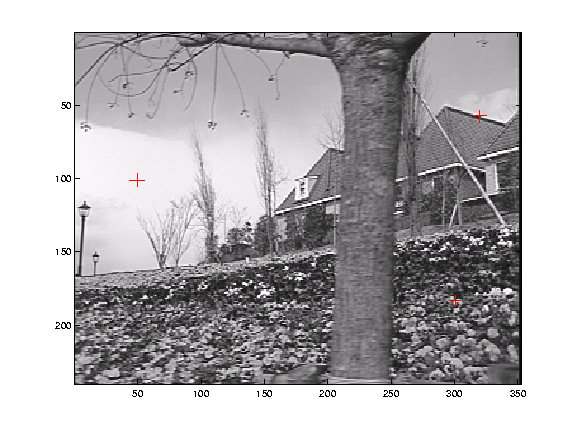


# Auto-correlation

Points that are good to match will most likely have unique matches in the other image. One way is to select pixels that are **locally** stable matches in the **same** image. We consider the **auto-correlation** function defined as:

\begin{eqnarray}
        E_{AC}(\Delta \mathbf{u}) =  \sum_i w(\mathbf{x}_i) \left (
        I_0 (\mathbf{x}_i + \Delta \mathbf{u}) - I_0(\mathbf{x}_i) 
        \right )^2
\end{eqnarray}

(30, 30)


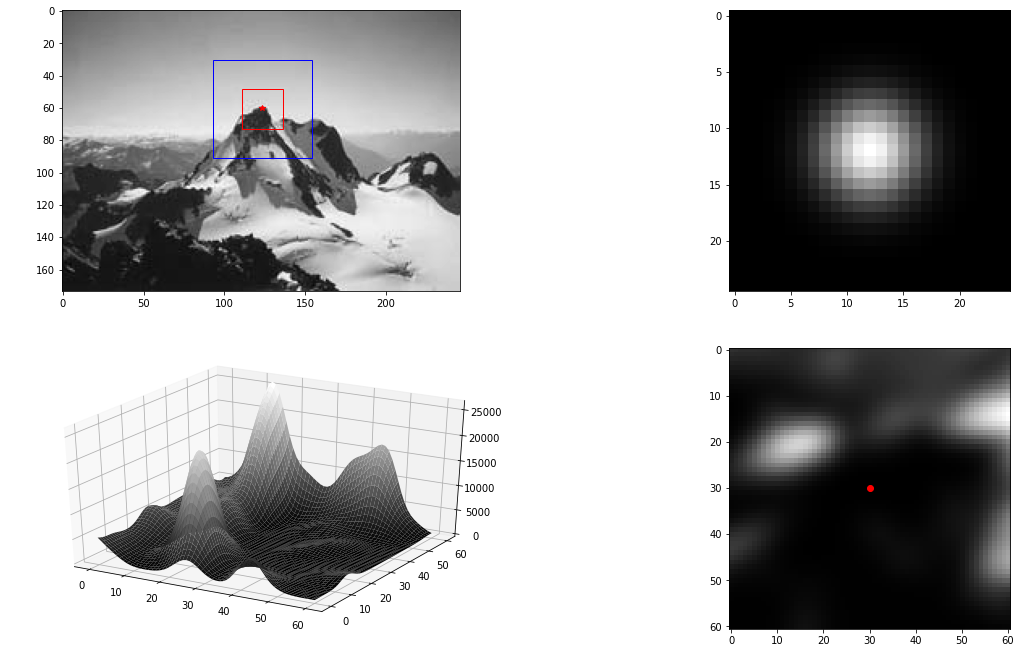

In [4]:
#------------------------------------------------------------------
# Compute E_AC over a (2Nw+1) by (2Nw+1) region for a point p in img1 computed 
# across a region (2Ns + 1) by (2Ns + 1) region 

px, py = (100, 80)
px, py = (60, 60)
px, py = (123, 60) # point in image 1


sigma = 3
Nw = np.round(3*(sigma+1)) # averaging window
Ns = 30 # matching search region is (2Ns + 1) by (2Ns + 1)

weights = gaussian_weights (sigma)

out = np.zeros([2*Ns+1, 2*Ns+1])
for i in range (-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        patch1 = img1[px-Nw : px+Nw+1, py-Nw : py+Nw+1]
        patch2 = img1[px+i-Nw : px+i+Nw+1 , py+j-Nw : py+j+Nw+1]
        out[i+Ns, j+Ns]  =  (weights*(patch1 - patch2)**2).sum()

#-----------------------------------------------------------------------------
# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
plt.imshow(img1, 'gray')
plt.plot (px, py, 'r*')
rect = patches.Rectangle((px-Nw,py-Nw),weights.shape[0], weights.shape[1],linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
rect = patches.Rectangle((px-Ns,py-Ns),out.shape[0], out.shape[1],linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect)

plt.subplot(5,2,2)
plt.imshow(weights, 'gray')
plt.subplot(5,2,4)
plt.imshow(out, 'gray')
print(np.unravel_index(np.argmin(out, axis=None), out.shape))

i_min, j_min = (np.unravel_index(np.argmin(out, axis=None), out.shape)) 
plt.plot (j_min, i_min, 'ro')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:out.shape[0], 0:out.shape[1]]
# create the figure
plt.subplot(5,2,3,projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, out ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)

#plt.imshow(gaussian_weights (3), 'gray')



This function is defined over a window of possible displacments $\Delta \mathbf{u} = \left [ \begin{array}{c} \Delta x \\ \Delta y \end{array} \right ]$. The sum on the R.H.S is also over a window but defined over the image grid. A good point will have an $E_{AC}$ that is peaked in the window over *local displacements*. 

(see Fig 4.5 in the textbook for examples of good and bad $E_{AC}$.)

To find these points with good $E_{AC}$, we still have to search through all pixels in the image, performing multiply-add in four for-loops! This search is still computationally expensive.

We observe that this error criterion is on the *same* image and needed for *small* displacements. So, we can approximate it using the Taylor expansion to arrive at a computationally simpler expression.

Using Taylor series expansion, we can express the value of the intensity at a nearby location, $\mathbf{x}_i + \Delta\mathbf{u}$, using derivatives at the current location, $\mathbf{x}_i$.

\begin{eqnarray}
        I_0 (\mathbf{x}_i + \Delta\mathbf{u}) & \approx & 
        I_0 (\mathbf{x}_i) + \nabla I_0 (\mathbf{x}_i)^T \Delta   
        \mathbf{u} \\
        & = & I_0 (\mathbf{x}_i) + 
        \begin{bmatrix} I_x (\mathbf{x}_i) & I_y (\mathbf{x}_i) \end{bmatrix} \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}
\end{eqnarray}



Using the above approximation of the image function value in a local neighborhood using derivatives, we can approximate the $E_{AC}$ as below.

\begin{eqnarray}
        E_{AC}(\Delta \mathbf{u}) & = &   \sum_i w(\mathbf{x}_i) \left (
        I_0 (\mathbf{x}_i + \Delta \mathbf{u}) - I_0(\mathbf{x}_i) 
        \right )^2 \\
        & \approx & \sum_i w(\mathbf{x}_i) \left (
        \nabla I_0 (\mathbf{x}_i)^T \Delta \mathbf{u} \right )^2 \\
        & = & \sum_i w(\mathbf{x}_i) \left (
        \nabla I_0 (\mathbf{x}_i)^T \Delta \mathbf{u} \right )^T 
        \left (
        \nabla I_0 (\mathbf{x}_i)^T \Delta \mathbf{u} \right ) \\
        & = & \sum_i w(\mathbf{x}_i) 
        \begin{bmatrix} \Delta x & \Delta y 
        \end{bmatrix}
        \begin{bmatrix} I_x (\mathbf{x}_i) \\ I_y (\mathbf{x}_i) \end{bmatrix} 
        \begin{bmatrix} I_x (\mathbf{x}_i) & I_y (\mathbf{x}_i) \end{bmatrix} \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix} \\
        & = & 
        \begin{bmatrix} \Delta x & \Delta y 
        \end{bmatrix} \left (
        \sum_i w(\mathbf{x}_i) \begin{bmatrix} I_x (\mathbf{x}_i) \\ I_y 
        (\mathbf{x}_i) \end{bmatrix} 
        \begin{bmatrix} I_x (\mathbf{x}_i) & I_y (\mathbf{x}_i) \end{bmatrix} 
        \right )
        \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}  \\
        & = & 
        \begin{bmatrix} \Delta x & \Delta y 
        \end{bmatrix} \mathbf{A} 
        \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}
    \end{eqnarray}
    
\begin{equation}
        \mathbf{A}  = \begin{bmatrix}
            \sum_i w(\mathbf{x}_i) I_x^2 (\mathbf{x}_i) & 
            \sum_i w(\mathbf{x}_i) I_x (\mathbf{x}_i) I_y (\mathbf{x}_i) \\
            \sum_i w(\mathbf{x}_i) I_y (\mathbf{x}_i) I_x (\mathbf{x}_i)  & 
            \sum_i w(\mathbf{x}_i) I_y^2 (\mathbf{x}_i)
        \end{bmatrix}
\end{equation}

\begin{equation}
        \mathbf{A}  = 
        \begin{bmatrix}
            \sum_i w(\mathbf{x}_i) I_x^2 & 
            \sum_i w(\mathbf{x}_i) I_x  I_y  \\
            \sum_i w(\mathbf{x}_i) I_y  I_x   & 
            \sum_i w(\mathbf{x}_i) I_y^2 
        \end{bmatrix}
\end{equation}
    
\begin{equation}
          \mathbf{A}  = \sum_i w(\mathbf{x}_i)   \begin{bmatrix}
           I_x^2 &  I_x  I_y  \\
            I_y  I_x   &  I_y^2 
        \end{bmatrix}
\end{equation}
    
The matrix $\mathbf{A}$ is an estimate of the local image tensor, defined using first derivatives at the pixel location under consideration. Note that the approximated $E_{AC}$ function is a parabolic function over the displacements $\Delta x$ and $\Delta y$. The shape of the paraboloid is dependent on $\mathbf{A}$. 
    

Input image size: (174, 246)

 Image tensor (A) at pixel 123 60 is
 [[0.33 0.36]
 [0.36 2.29]]
(13, 47)


<Figure size 1440x2160 with 0 Axes>

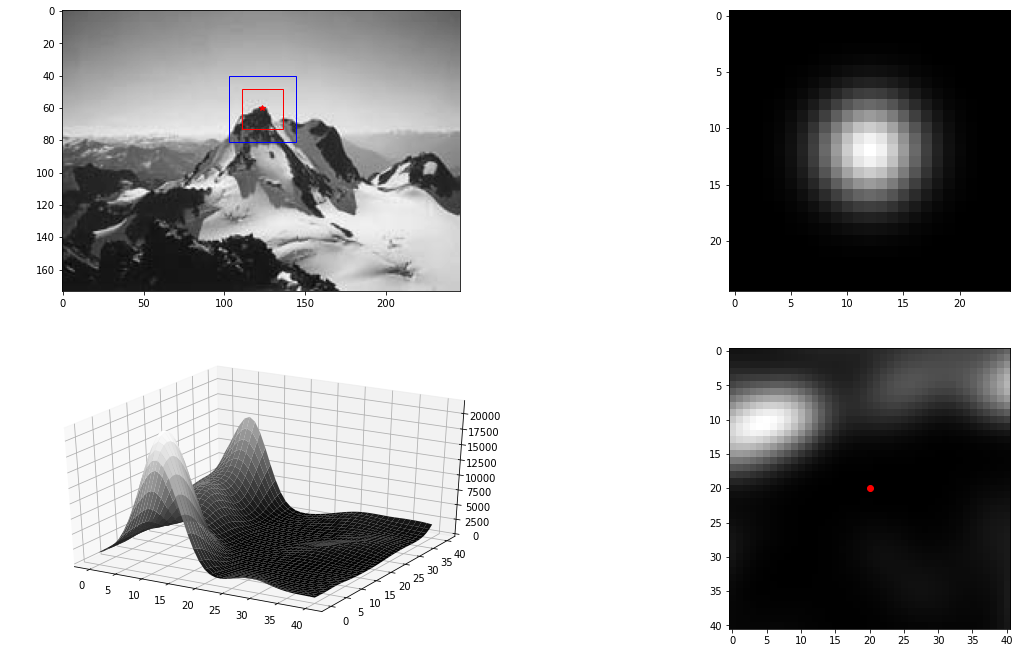

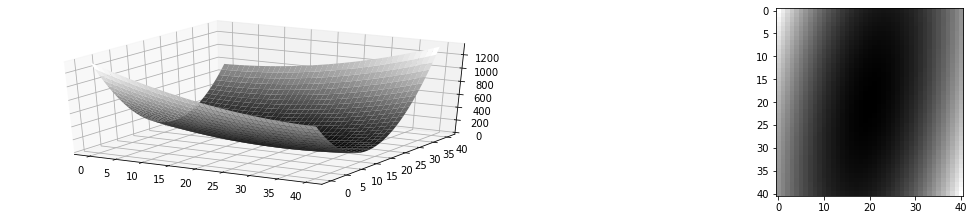

In [ ]:
def gaussian (x, sigma):
    g = np.exp(-(x**2/(2*sigma*sigma)))*(1/(np.sqrt(2*np.pi)*sigma))
    return (g/g.sum())
#------------------------------------------------------------------
def first_derivative_of_gaussian (x, sigma):
    dg = np.exp(-(x**2/(2*sigma*sigma)))*(-x/(np.sqrt(2*np.pi)*sigma**3))
    return (dg)

#------------------------------------------------------------------
def image_convolve_gradient_gaussian (image, sigma) :
    N = np.round(3*(sigma+1))
    t = np.arange(-N, N+1)  # Note the width of the kernel, need to be this large to capture most of the shape
    g = gaussian(t, sigma) # 1D gaussian kernel
    dg = first_derivative_of_gaussian(t, sigma) # 1D first derivative gaussian kernel
    #print("Size of 1D kernel:", g.shape, dg.shape)
    #plt.subplot(5,2,1)
    #plt.plot(t, g, 'o-')
    #plt.title('Gaussian kernel')
    #plt.subplot(5,2,2)
    #plt.plot(t, dg, 'x-')
    #plt.title('first derivative of Gaussian kernel')

    # Process rows
    gradX = image.copy()
    for i in range (image.shape[0]):
        gradX[i,:] = scimage.convolve(gradX[i, :], dg)
    # Process columns
    for j in range (image.shape[1]):
        gradX[:, j] = scimage.convolve(gradX[:, j], g)

    gradY = image.copy()
    for i in range (image.shape[0]):
        gradY[i,:] = scimage.convolve(gradY[i, :], g)
    # Process columns
    for j in range (image.shape[1]):
        gradY[:, j] = scimage.convolve(gradY[:, j], dg)

    return (gradX, gradY)

#------------------------------------------------------------------
# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png')

# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Input image size:", img.shape)
plt.figure(figsize=(20,30))
img = img.astype(np.float)  # need to change type from uint8 to float
sigma = 3
Nw = np.round(3*(sigma+1)) # averaging window
Ns = 20 # matching search region is (2Ns + 1) by (2Ns + 1)
weights = gaussian_weights (sigma)
#-----------------------select point on the image to explore------------
px, py = (100, 80)
px, py = (60, 60)
px, py = (123, 60) # point in image 1

#-----------------------Raw Autocorrelation E_WSSD--------------------------------
E_WSSD = np.zeros([2*Ns+1, 2*Ns+1])
for i in range (-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        patch1 = img1[px-Nw : px+Nw+1, py-Nw : py+Nw+1]
        patch2 = img1[px+i-Nw : px+i+Nw+1 , py+j-Nw : py+j+Nw+1]
        E_WSSD[i+Ns, j+Ns]  =  (weights*(patch1 - patch2)**2).sum()

#-----------------------Approximate Autocorrelation--------------------------------

image_dx, image_dy = image_convolve_gradient_gaussian(img, 3)

Ix_Ix = image_dx*image_dx
Ix_Iy = image_dx*image_dy
#A_10 = image_dy*image_dx # do not need it
Iy_Iy = image_dy*image_dy

A = np.zeros((2,2,img.shape[0], img1.shape[1]))
A[0, 0,:,:] = scimage.convolve(Ix_Ix, weights)
A[0, 1,:,:] = scimage.convolve(Ix_Iy, weights)
A[1, 0,:,:] = A[0, 1,:,:]
#scimage.convolve(A_10, g)
A[1, 1,:,:] = scimage.convolve(Iy_Iy, weights)

print('\n Image tensor (A) at pixel', px, py, 'is\n', A[:,:,px,py])
#-----------------------E_AC--------------------------------
E_AC = np.zeros((2*Ns+1, 2*Ns+1))
for i in range(-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        E_AC [i+Ns, j+Ns] = np.array([[i, j]]) @ A[:,:,px,py] @ np.array([[i], [j]])

#-----------------------------------------------------------------------------
# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
plt.imshow(img1, 'gray')
plt.plot (px, py, 'r*')
rect = patches.Rectangle((px-Nw,py-Nw),weights.shape[0], weights.shape[1],linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
rect = patches.Rectangle((px-Ns,py-Ns),E_WSSD.shape[0], E_WSSD.shape[1],linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect)

plt.subplot(5,2,2)
plt.imshow(weights, 'gray')
plt.subplot(5,2,4)
plt.imshow(E_WSSD, 'gray')
print(np.unravel_index(np.argmin(E_WSSD, axis=None), out.shape))

i_min, j_min = (np.unravel_index(np.argmin(E_WSSD, axis=None), E_WSSD.shape)) 
plt.plot (j_min, i_min, 'ro')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:E_WSSD.shape[0], 0:E_WSSD.shape[1]]
# create the figure
plt.subplot(5,2,3,projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, E_WSSD ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)
# create the x and y coordinate arrays (here we just use pixel indices)

# create the figure
plt.figure(figsize=(20,20))
plt.subplot(5,2,5, projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, E_AC, rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
plt.subplot(5,2,6)
plt.imshow(E_AC, 'gray');

# Harris Points

$\mathbf{A}^{-1}$ is a measure of the uncertainty of the location, i.e. how sharp the valley is?

If $\lambda_0$ and $\lambda_1$ are eigenvalues of A, where $\lambda_0 < \lambda_1$, then $\lambda_0^{-1}$ and $\lambda_1^{-1}$ are the eigenvalues of $\mathbf{A}^{-1}$. The largest eigenvalue of $\mathbf{A}^{-1}$ should be small, i.e. $\lambda_0^{-1}$ should be small, or in other words $\lambda_0$ should be high (Shi and Tomasi).
    
$\lambda_0 \lambda_1 = \det(\mathbf{A}) = A_{00} A_{11} - A_{01}A_{10}$ and $\lambda_0 + \lambda_1 = \text{Trace}(\mathbf{A}) = A_{00} + A_{11}$
    
([Harris and Stephens, 1988](http://www.bmva.org/bmvc/1988/avc-88-023.pdf)) advocated the use of $\lambda_0 \lambda_1 - \alpha (\lambda_0 + \lambda_1)^2 $ or $\det(\mathbf{A}) + \alpha \text{Trace}(\mathbf{A})^2$. The value should be locally the maximum at the points of interest. The  typical value of $\alpha = 0.06$. Points detected using this measure is typically referred to as the Harris detector.
    
Others suggest the harmonic mean, $\frac{\lambda_0 \lambda_1} {\lambda_0 + \lambda_1}$
    



 Eigenvalues: 48.0 16.0

 Harris Measure: 522.24 522.24


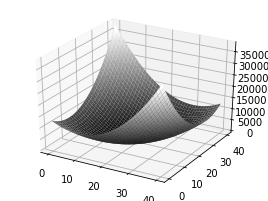

In [ ]:
# Playing around with different values of the A matrix

A = np.array([[1, 0],[0, 1]])
A = np.array([[1, 0.2],[0.2, 5]])
A = np.array([[32, -16],[-16, 32]])

eig,_ = np.linalg.eig(A)
print('\n Eigenvalues:', eig[0], eig[1])

harris_measure = eig[0]*eig[1] - 0.06*(eig[0]+eig[1])**2
print('\n Harris Measure:', harris_measure, A[0,0]*A[1,1] - A[0,1]*A[1,0] - 0.06*(A[0,0]+A[1,1])**2)

E_AC = np.zeros((2*Ns+1, 2*Ns+1))
for i in range(-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        E_AC [i+Ns, j+Ns] = np.array([[i, j]]) @ A @ np.array([[i], [j]])
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:E_AC.shape[0], 0:E_AC.shape[1]]
# create the figure

plt.figure(figsize=(10,20))
plt.subplot(5,2,1,projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, E_AC ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)

# Example on an image

Below are the examples of the image data undergoing transformation through the processing chain. We include examples of the Gaussian derivatives, image tensor components and its determinant and trace, and the final Harris measure. Notice how we gradually emphasize parts of the image where there is a corner.

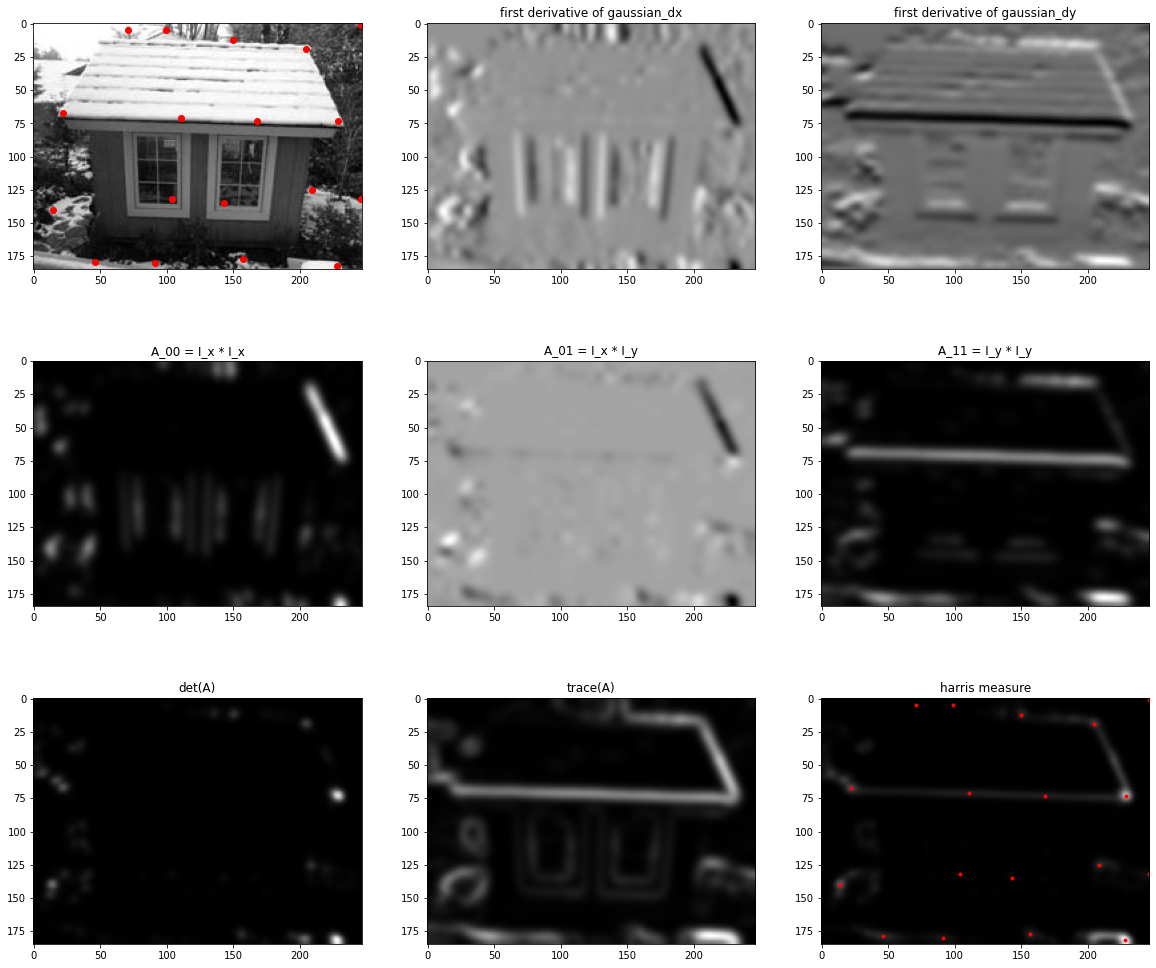

In [ ]:
from skimage.feature import peak_local_max
import numpy as np
import cv2
import matplotlib.pyplot as plt

#------------------------------------------------------------------

def detect_harris_points (image, sigma=3,min_distance=20) :

    image_dx, image_dy = image_convolve_gradient_gaussian(image, 3)

    Ix_Ix = image_dx*image_dx
    Ix_Iy = image_dx*image_dy
    Iy_Iy = image_dy*image_dy

    weights = gaussian_weights (sigma)
    A = np.zeros((2,2,image.shape[0], image.shape[1]))
    A[0, 0,:,:] = scimage.convolve(Ix_Ix, weights)
    A[0, 1,:,:] = scimage.convolve(Ix_Iy, weights)
    A[1, 0,:,:] = A[0, 1,:,:]
    A[1, 1,:,:] = scimage.convolve(Iy_Iy, weights)
   
    det_A = A[0, 0,:,:]*A[1, 1,:,:] - A[0, 1,:,:]*A[1, 0,:,:] 
    trace_A = A[0, 0,:,:] + A[1, 1,:,:]
    harris_measure = det_A + 0.06 * trace_A**2

    coordinates = peak_local_max(harris_measure, min_distance=20, exclude_border=False)
    return(coordinates, harris_measure, det_A, trace_A, A, image_dx, image_dy)

#----------------------------------------------------------------------------
# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_1.png')
#img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
img = img.astype(np.float)  # need to change type from uint8 to float
coordinates, harris_measure, det_A, trace_A, A, image_dx, image_dy = detect_harris_points (img, sigma=3, min_distance=20)

# -----------------------------Plot the results--------------------------------
plt.figure(figsize=(20,30))
plt.subplot(5,3,1)
plt.imshow(img, 'gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')
plt.subplot(5, 3, 2)
plt.imshow(image_dx, 'gray')
plt.title('first derivative of gaussian_dx')
plt.subplot(5, 3, 3)
plt.imshow(image_dy, 'gray')
plt.title('first derivative of gaussian_dy')

plt.subplot(5, 3, 4)
plt.imshow(A[0,0], 'gray')
plt.title('A_00 = I_x * I_x')
plt.subplot(5, 3, 5)
plt.imshow(A[0,1], 'gray')
plt.title('A_01 = I_x * I_y')
plt.subplot(5, 3, 6)
plt.imshow(A[1,1], 'gray')
plt.title('A_11 = I_y * I_y')

plt.subplot(5, 3, 7)
plt.imshow(det_A, 'gray')
plt.title('det(A)')
plt.subplot(5, 3, 8)
plt.imshow(trace_A, 'gray')
plt.title('trace(A)')
plt.subplot(5, 3, 9)
plt.imshow(harris_measure, 'gray')
plt.title('harris measure')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')


# Implemented using Pytorch on GPUs

Computing on:  cuda:0
Using 3 Gaussian kernels on 3 independent channels


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 1440x2160 with 0 Axes>

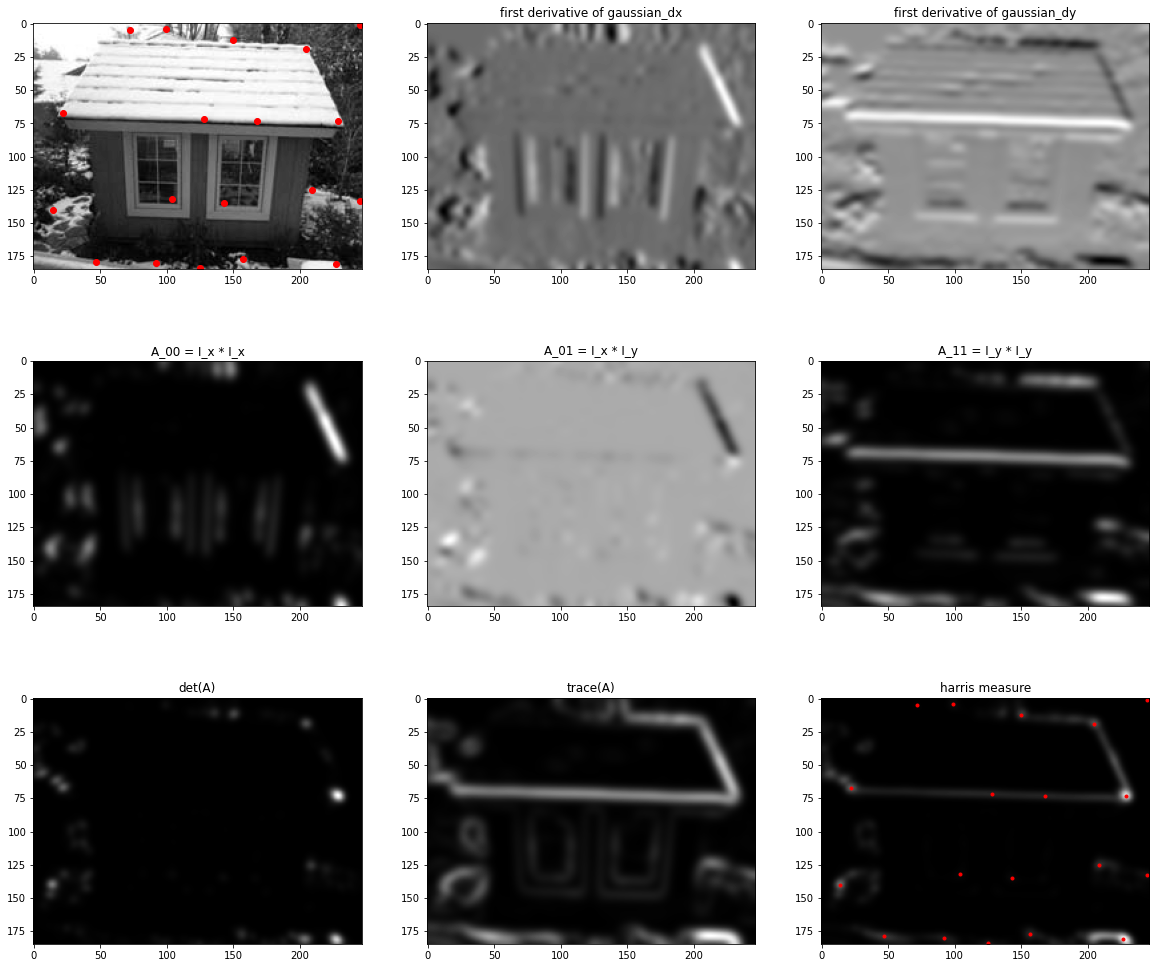

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from skimage import io
from skimage.feature import peak_local_max

def gaussian (x, sigma):
    g = np.exp(-(x**2/(2*sigma*sigma)))*(1/(np.sqrt(2*np.pi)*sigma))
    return (g/g.sum())
#------------------------------------------------------------------
def first_derivative_of_gaussian (x, sigma):
    dg = np.exp(-(x**2/(2*sigma*sigma)))*(-x/(np.sqrt(2*np.pi)*sigma**3))
    return (dg)
#------------------------------------------------------------------
def gaussian_kernel_multi_channel (input_ch, output_ch, sigma = 3, type='not_independent') :
# produces a [input_ch, output_ch, 2*N+1, 2*N+1] sized multi-channel gaussian kernel, where
# N is 3*sigma+1. 
# if type='independent' and the number of input_ch and output_ch are the same number
# then it produces a kernel that processes each channel independently from the others.
# the cross channel weights are zeroed out.

    N = np.round(3*(sigma+1))
    x = np.arange(-N, N+1)  # Note the width of the kernel, need to be this large to capture most of the shape
    g_1D = gaussian(x, sigma) # 1D gaussian kernel
    # creating 2D kernel using broadcasting of the 1D kernels
    gaussian_2D = (g_1D[:,None]*g_1D[None,:])
    gaussian_2D = gaussian_2D/gaussian_2D.sum()
    
    gaussian_kernel = np.zeros([input_ch, output_ch, 2*N+1, 2*N+1]) 
    if  (type == 'independent') and (input_ch == output_ch) :
        print('Using {} Gaussian kernels on {} independent channels'.format(input_ch,input_ch))
        for i in range (input_ch) :
            gaussian_kernel[i,i,:,:] = gaussian_2D[:, :]
    else :
        print('Using {} Gaussian kernels to bridge {} input channels with {} output channels'.format(input_ch*output_ch, input_ch, output_ch))
        for i in range (input_ch) :
            for j in range (output_ch) :
                gaussian_kernel[i,j,:,:] = gaussian_2D[:, :]
    
    return(gaussian_kernel, N)

#------------------------------------------------------------------
def gradient_gaussian_kernel (sigma = 3) :
# produces a [output_ch=2, input_ch=1,  2*N+1, 2*N+1] sized multi-channel first derivative of gaussian kernel
# with respect to the x direction, where N is 3*sigma+1. 

    N = np.round(3*(sigma+1))
    x = np.arange(-N, N+1)  # Note the width of the kernel, need to be this large to capture most of the shape
    g_1D = gaussian(x, sigma) # 1D gaussian kernel
    g_1D = g_1D/g_1D.sum()
    g_1D_dx = first_derivative_of_gaussian(x, sigma)

    # creating 2D kernel using broadcasting of the 1D kernels
    input_ch=1
    output_ch=2
    gradient_kernel = np.zeros([output_ch, input_ch, 2*N+1, 2*N+1]) 
    gradient_kernel[0, 0, :, :] = g_1D[:,None]*g_1D_dx[None,:]
    gradient_kernel[1, 0, :, :] = g_1D_dx[:,None]*g_1D[None,:]

    return(gradient_kernel, N)
#------------------------------------------------------------------

def detect_harris_points_torch (device, input, sigma=3,min_distance=20, figure='None') :
    
    # Setup the layers to compute the gradient and gaussian smoothing
    # a 2D convolution layer that computes the gradient of a gray-level (single channel) image
    weights, N = gradient_gaussian_kernel (sigma = 3)
    weights = torch.tensor(weights, device=device).float()
    layer_gradient = nn.Conv2d(in_channels = 1, out_channels = 2, kernel_size = (2*N+1, 2*N+1), padding=N, padding_mode='replicate', stride=1, bias=None)
    layer_gradient.weight = nn.Parameter(weights)

    # a 2D Gaussian convolution layer to compute the smoothed image tensor (A) entries, A_00, A_01, A_11
    # Input: are the A_00, A_01, A_11 channels and the outputs are three smoothed channels
    weights, N = gaussian_kernel_multi_channel (3, 3, sigma = 3, type = 'independent')
    weights = torch.tensor(weights, device=device).float()
    layer_gaussian = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (2*N+1, 2*N+1), padding=N, padding_mode='replicate', stride=1, bias=None)
    layer_gaussian.weight = nn.Parameter(weights)

    # --------------------------process through the layers----------------------------------------
    
    # compute gradient
    gradient_I = layer_gradient (input)
    # compute image tensor
    Ix_Ix = gradient_I[:,0,:,:]*gradient_I[:,0,:,:]
    Ix_Iy = gradient_I[:,0,:,:]*gradient_I[:,1,:,:]
    Iy_Iy = gradient_I[:,1,:,:]*gradient_I[:,1,:,:]
    # smooth image tensor
    raw_image_tensor = torch.stack([Ix_Ix[:,:,:], Ix_Iy[:,:,:], Iy_Iy[:,:,:]]) # prepare tensor as a 3-channel input
    raw_image_tensor = raw_image_tensor.permute(1,0,2,3)  # permute the dimensons so that the 2 channels are in the second dimension
    A = layer_gaussian(raw_image_tensor)  # smooth each channel
    # compute the Harries measure
    det_A = A[0,0,:,:]*A[0,2,:,:] - A[0,1,:,:]*A[0,1,:,:]
    trace_A = A[0,0] + A[0,2]
    harris_measure = det_A + 0.06 * trace_A**2
    # detect peaks
    if device != 'cpu':
        harris_measure = harris_measure.cpu()
    harris_measure = harris_measure.detach().numpy()
    coordinates = peak_local_max(harris_measure, min_distance=20, exclude_border=False)

    #-------------------------Display part----------------------------------------
    if (figure =='yes') :
        if device != 'cpu':  # move variable from GPU to CPU for display
            input = input.cpu()
            gradient_I = gradient_I.cpu()
            A = A.cpu()
            det_A = det_A.cpu()
            trace_A = trace_A.cpu()
        plt.figure(figsize = (20, 30))
        plt.subplot(5, 3, 1)
        plt.imshow(input[0,0].numpy(), 'gray')
        plt.subplot(5, 3, 2)
        plt.imshow(gradient_I[0,0,:,:].detach().numpy(), 'gray')
        plt.title('first derivative of gaussian_dx')
        plt.subplot(5, 3, 3)
        plt.imshow(gradient_I[0,1,:,:].detach().numpy(), 'gray')
        plt.title('first derivative of gaussian_dy')

        plt.subplot(5, 3, 4)
        plt.imshow(A[0,0].detach().numpy(), 'gray')
        plt.title('A_00 = I_x * I_x')
        plt.subplot(5, 3, 5)
        plt.imshow(A[0,1].detach().numpy(), 'gray')
        plt.title('A_01 = I_x * I_y')
        plt.subplot(5, 3, 6)
        plt.imshow(A[0,2].detach().numpy(), 'gray')
        plt.title('A_11 = I_y * I_y')

        plt.subplot(5, 3, 7)
        plt.imshow(det_A.detach().numpy(), 'gray')
        plt.title('det(A)')
        plt.subplot(5, 3, 8)
        plt.imshow(trace_A.detach().numpy(), 'gray')
        plt.title('trace(A)')
        plt.subplot(5, 3, 9)
        plt.imshow(harris_measure, 'gray')
        plt.title('harris measure')

        plt.subplot(5,3,1)
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')

        plt.subplot(5,3,9)
        plt.imshow(harris_measure, 'gray')
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    
    return(harris_measure, coordinates)


#------------------------------------------------------------------
plt.figure(figsize = (20, 30))
#ax = plt.gcf()

img = io.imread('/content/drive/MyDrive/Colab Notebooks/data/house_1.png')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input = torch.tensor(img, device=device).float()
#input = torch.tensor(img).float()
input = input.sum(dim=2)/3 # sum the color channels
input = input[None, None, :] # expand to 4 channels
print('Computing on: ', input.device)

# Impulse image to study the impulse response.
#input = torch.zeros((1,1,100,100), device=device)
#input[0, 0, 50, 50] = 1.0

harris_measure = detect_harris_points_torch (device, input, sigma=3, min_distance=20, figure='yes')





# Question?

Compare the first derivative computations (second and third images in the above panel of results) with the corresponding images in the previous results. Do you see a difference? Describe the difference. Explain the reason for the difference.

# Matching features across image views

The Harris points can be used to match points across views.



Computing on:  cuda:0
Using 3 Gaussian kernels on 3 independent channels
Using 3 Gaussian kernels on 3 independent channels


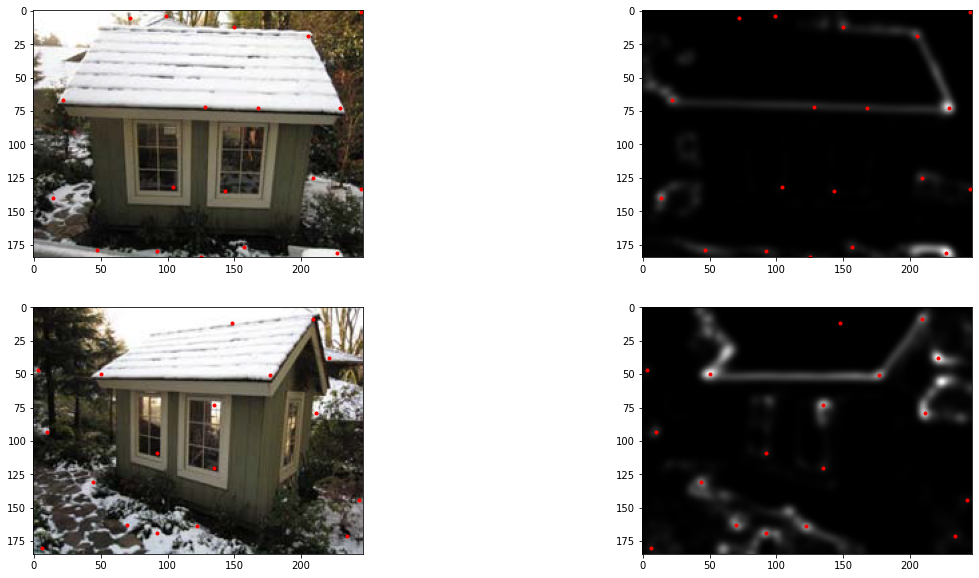

In [14]:
image1 = io.imread('/content/drive/MyDrive/Colab Notebooks/data/house_1.png')
image2 = io.imread('/content/drive/MyDrive/Colab Notebooks/data/house_2.png')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input1 = torch.tensor(image1, device=device).float()
input2 = torch.tensor(image2, device=device).float()

input1 = input1.sum(dim=2)/3 # sum the color channels
input2 = input2.sum(dim=2)/3 # sum the color channels
input1 = input1[None, None, :] # expand to 4 channels for pytorch
input2 = input2[None, None, :] # expand to 4 channels

print('Computing on: ', input.device)

harris_measure1, coordinates1 = detect_harris_points_torch (device, input1, sigma=3, min_distance=20, figure='no')
harris_measure2, coordinates2 = detect_harris_points_torch (device, input2, sigma=3, min_distance=20, figure='no')

plt.figure(figsize = (20, 10))

plt.subplot(2,2,1)
plt.imshow(image1)
plt.plot(coordinates1[:, 1], coordinates1[:, 0], 'r.')
plt.subplot(2,2,2)
plt.imshow(harris_measure1, 'gray')
plt.plot(coordinates1[:, 1], coordinates1[:, 0], 'r.')

plt.subplot(2,2,3)
plt.imshow(image2)
plt.plot(coordinates2[:, 1], coordinates2[:, 0], 'r.')
plt.subplot(2,2,4)
plt.imshow(harris_measure2, 'gray')
plt.plot(coordinates2[:, 1], coordinates2[:, 0], 'r.')



# Feature tracking 

Section 4.1.4. We expect motion from frame to frame is small.

1. Detect stable features in one frame.

2. Correlate patches over small neighborhoods and pick point of smallest squared difference.
    
3. If features are tracked over long sequences, appearance can change, so need to update template, but not too often.

Computing on:  cuda:0
Using 3 Gaussian kernels on 3 independent channels


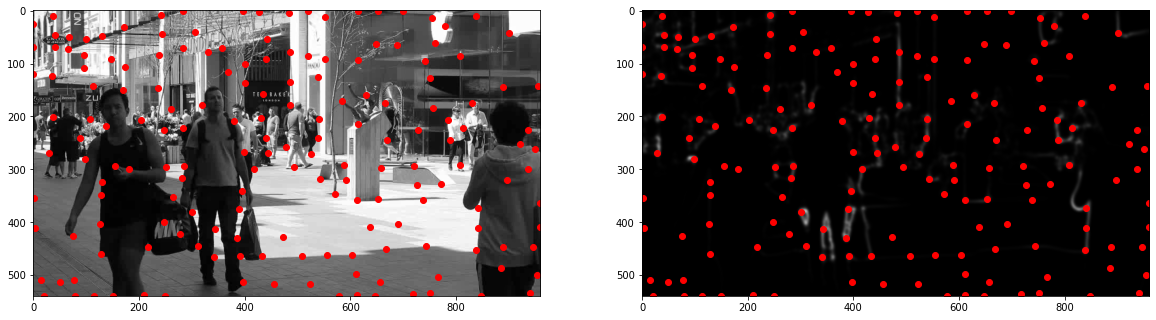

Using 3 Gaussian kernels on 3 independent channels


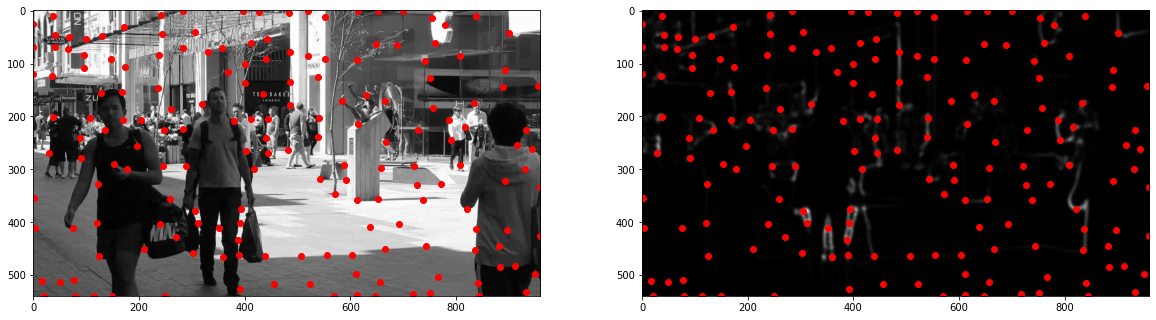

KeyboardInterrupt: ignored

In [18]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/data/MOT16-08-raw.webm')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Computing on: ', input.device)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype(np.float)  # need to change type from uint8 to float
        input = torch.tensor(frame, device=device).float()
        input = input[None, None, :] # expand to 4 channels for pytorch
        #coordinates, harris_measure = detect_harris_points (frame, sigma=2, min_distance=20)
        harris_measure, coordinates = detect_harris_points_torch (device, input, sigma=3, min_distance=20, figure='no')
        # Plot the results
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(frame, 'gray')
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')
        plt.subplot(1,2,2)
        plt.imshow(harris_measure, 'gray')
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')
        
        plt.pause(1)

    else: 
	    break

cap.release()
 
cv2.destroyAllWindows()